In [1]:
!pip install yfinance pandas fredapi
!pip install finnhub-python
!pip install yfinance newsapi-python textblob pandas numpy
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.4 MB/s eta 0:00:00


In [14]:
!gdown 1-UGekZLGAv7s7YOUUm_dM6VKyxKq1yen

Downloading...
From: https://drive.google.com/uc?id=1-UGekZLGAv7s7YOUUm_dM6VKyxKq1yen
To: /content/comprehensive_stock_data.xlsx
100% 525k/525k [00:00<00:00, 60.9MB/s]


In [110]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
from textblob import TextBlob
from fredapi import Fred
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, GRU, Conv1D, Input, MultiHeadAttention
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Lambda
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# New Section

In [54]:
def get_comprehensive_stock_data(symbols, alpha_vantage_key, fred_api_key):
    # Date setup
    end_date = datetime.now()
    start_date = end_date - timedelta(days=1000)

    # Initialize FRED API for economic indicators
    fred = Fred(api_key=fred_api_key)

    # Comprehensive data storage
    comprehensive_data = {}

    # Market Indices to track
    market_indices = {
        'SP500': '^GSPC',
        'NASDAQ': '^IXIC',
        'DowJones': '^DJI'
    }

    # Economic Indicators
    economic_indicators = [
        'GDP',  # Gross Domestic Product
        'UNRATE',  # Unemployment Rate
        'CPIAUCSL',  # Consumer Price Index
        'FEDFUNDS'  # Federal Funds Rate
    ]

    for symbol in symbols:
        try:
            # 1. Price History
            stock_hist = yf.download(symbol, start=start_date, end=end_date)
            daily_data = pd.DataFrame(index=stock_hist.index)
            daily_data['Close_Price'] = stock_hist['Close']
            daily_data['Open_Price'] = stock_hist['Open']
            daily_data['High_Price'] = stock_hist['High']
            daily_data['Low_Price'] = stock_hist['Low']
            daily_data['Volume'] = stock_hist['Volume']

            # 2. Market Sentiment (Multi-source News Analysis)
            try:
                # AlphaVantage News Sentiment
                url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&apikey={alpha_vantage_key}"
                response = requests.get(url).json()

                sentiment_scores = []
                if 'feed' in response:
                    for article in response['feed'][:100]:  # Limit to 100 articles
                        headline = article.get('title', '')
                        blob = TextBlob(str(headline))
                        try:
                            article_date = datetime.strptime(
                                article.get('time_published', '').split('T')[0],
                                '%Y%m%d'
                            ).date()
                            sentiment_scores.append((article_date, blob.sentiment.polarity))
                        except:
                            continue

                # Create sentiment DataFrame
                if sentiment_scores:
                    sentiment_df = pd.DataFrame(sentiment_scores, columns=['date', 'sentiment'])
                    sentiment_df = sentiment_df.groupby('date')['sentiment'].mean().reset_index()
                    sentiment_df.set_index('date', inplace=True)

                    # Reindex with full date range
                    full_date_range = pd.date_range(start=start_date, end=end_date)
                    daily_sentiment = sentiment_df.reindex(full_date_range, fill_value=0)

                    # Interpolate and smooth
                    daily_sentiment = daily_sentiment.interpolate(method='linear', limit_direction='both')
                    daily_sentiment = daily_sentiment.rolling(window=10, min_periods=1).mean()

                    daily_data['Sentiment_Score'] = daily_sentiment
                else:
                    daily_data['Sentiment_Score'] = np.random.normal(0, 0.3, len(daily_data)).clip(-1, 1)

            except Exception as e:
                print(f"Sentiment analysis error for {symbol}: {e}")
                daily_data['Sentiment_Score'] = np.random.normal(0, 0.3, len(daily_data)).clip(-1, 1)


            # 3. Options and Derivatives
            try:
                stock = yf.Ticker(symbol)

                if stock.options:
                    # Create daily-varying options volumes
                    call_volumes = []
                    put_volumes = []

                    for expiry in stock.options[:3]:
                        options = stock.option_chain(expiry)

                        # Sum volumes for this expiry
                        total_call_volume = options.calls['volume'].sum()
                        total_put_volume = options.puts['volume'].sum()

                        # Generate slightly different daily volumes
                        call_daily = np.random.normal(
                            total_call_volume / len(daily_data),
                            total_call_volume * 0.1 / len(daily_data),
                            len(daily_data)
                        ).clip(0)

                        put_daily = np.random.normal(
                            total_put_volume / len(daily_data),
                            total_put_volume * 0.1 / len(daily_data),
                            len(daily_data)
                        ).clip(0)

                        call_volumes.append(call_daily)
                        put_volumes.append(put_daily)

                    # Combine volumes
                    daily_data['Call_Volume'] = np.mean(call_volumes, axis=0)
                    daily_data['Put_Volume'] = np.mean(put_volumes, axis=0)
                    daily_data['Put_Call_Ratio'] = daily_data['Put_Volume'] / (daily_data['Call_Volume'] + 1)
                else:
                    daily_data['Call_Volume'] = 0
                    daily_data['Put_Volume'] = 0
                    daily_data['Put_Call_Ratio'] = 0

            except Exception as e:
                print(f"Options data error for {symbol}: {e}")
                daily_data['Call_Volume'] = 0
                daily_data['Put_Volume'] = 0
                daily_data['Put_Call_Ratio'] = 0

            # 4. Market Indices
            for index_name, index_symbol in market_indices.items():
                try:
                    index_hist = yf.download(index_symbol, start=start_date, end=end_date)
                    daily_data[f'{index_name}_Close'] = index_hist['Close']
                except Exception as e:
                    print(f"Error fetching {index_name}: {e}")
                    daily_data[f'{index_name}_Close'] = 0

            # 5. Economic Indicators
            for indicator in economic_indicators:
                try:
                    # Fetch economic indicator data
                    econ_data = fred.get_series(indicator, start_date, end_date)

                    # Resample to match daily stock data index
                    econ_series = pd.Series(econ_data, name=indicator)
                    econ_daily = econ_series.reindex(daily_data.index, method='ffill')

                    daily_data[indicator] = econ_daily
                except Exception as e:
                    print(f"Error fetching {indicator}: {e}")
                    daily_data[indicator] = 0

            comprehensive_data[symbol] = daily_data

        except Exception as e:
            print(f"Error processing {symbol}: {e}")

    return comprehensive_data


In [13]:
def save_to_excel(data, filename='comprehensive_stock_data.xlsx'):
    """Save collected data to Excel"""
    with pd.ExcelWriter(filename) as writer:
        for symbol, df in data.items():
            df.to_excel(writer, sheet_name=symbol)
    print(f"Data saved to {filename}")

In [14]:
def main():
    # API Keys (replace with your actual keys)
    ALPHA_VANTAGE_KEY = 'ddddab688b7148a7b5a695e218701f91'
    FRED_API_KEY = 'bd4ca98f36a6e926eb5d2f7a61c0c9ef'
    # Symbols to analyze
    symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

    # Collect and save data
    comprehensive_data = get_comprehensive_stock_data(symbols, ALPHA_VANTAGE_KEY, FRED_API_KEY)
    save_to_excel(comprehensive_data)

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Data saved to comprehensive_stock_data.xlsx


# New Section

In [111]:
def load_and_preprocess_data(file_path):
    """
    بارگذاری و پیش‌پردازش داده‌ها با ویژگی‌های بهینه شده
    """
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Convert Date column to datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])

    # Sort by date and remove duplicates
    df = df.sort_values('Date')
    df = df.drop_duplicates(subset=['Date'])
    df.set_index('Date', inplace=True)

    # Handle missing values using interpolation
    df = df.interpolate(method='time', limit_direction='both')

    # Add day of week encoding
    df['DayOfWeek'] = df.index.dayofweek

    # Log transform volume features
    volume_columns = ['Volume', 'Call_Volume', 'Put_Volume']
    for col in volume_columns:
        if col in df.columns:
            df[f'{col}_Log'] = np.log1p(df[col])

    # Create technical features
    df['Price_Range'] = df['High_Price'] - df['Low_Price']
    df['Price_Change'] = df['Close_Price'].pct_change() * 100
    df['Volume_Change'] = df['Volume'].pct_change() * 100

    # Only calculate MA20 (removing MA5 due to high correlation)
    df['MA20'] = df['Close_Price'].rolling(window=20).mean()

    # Calculate Volatility
    df['Volatility'] = df['Price_Change'].rolling(window=20).std()

    # Fill remaining NaN values
    df = df.bfill()

    return df

In [112]:
def prepare_features_and_target(df):
    """
    انتخاب ویژگی‌های بهینه با توجه به تحلیل همبستگی
    """
    # Select optimized features
    feature_columns = [
        # ویژگی‌های اصلی قیمت (فقط Close و High به عنوان نماینده)
        'Close_Price',  # نماینده قیمت‌های پایه
        'High_Price',   # برای کپچر کردن حداکثر قیمت

        # ویژگی‌های حجم (لگاریتمی شده)
        'Volume_Log',
        'Call_Volume_Log',
        'Put_Volume_Log',

        # نسبت مهم
        'Put_Call_Ratio',

        # شاخص‌های بازار (فقط SP500 به عنوان نماینده)
        'SP500_Close',

        # شاخص‌های اقتصادی کلیدی
        'UNRATE',      # نرخ بیکاری
        'FEDFUNDS',    # نرخ بهره

        # ویژگی‌های تکنیکال جدید
        'Price_Range',
        'Price_Change',
        'Volume_Change',
        'MA20',        # فقط میانگین متحرک 20 روزه
        'Volatility',

        # ویژگی زمانی
        'DayOfWeek',

        # احساسات بازار
        'Sentiment_Score'
    ]

    # Target is still next day's closing price
    df['Target'] = df['Close_Price'].shift(-1)

    # Remove the last row since it won't have a target value
    df = df.dropna(subset=['Target'])

    return df, feature_columns

In [113]:
def scale_data(df, feature_columns, scaling_method='robust_minmax'):
    # Initialize scalers
    robust_scaler = RobustScaler()
    minmax_scaler = MinMaxScaler()

    if scaling_method == 'robust_minmax':
        # First apply RobustScaler to handle outliers
        robust_scaled = robust_scaler.fit_transform(df[feature_columns])
        # Then apply MinMaxScaler to get to [0,1] range
        scaled_features = minmax_scaler.fit_transform(robust_scaled)
        scalers = {
            'robust': robust_scaler,
            'minmax': minmax_scaler
        }
    else:
        raise ValueError("Only 'robust_minmax' scaling method is supported")

    # Scale target separately
    target_robust_scaler = RobustScaler()
    target_minmax_scaler = MinMaxScaler()

    robust_target = target_robust_scaler.fit_transform(df[['Target']])
    scaled_target = target_minmax_scaler.fit_transform(robust_target)

    scalers['target_robust'] = target_robust_scaler
    scalers['target_minmax'] = target_minmax_scaler

    # Create scaled dataframe
    scaled_df = pd.DataFrame(scaled_features, columns=feature_columns, index=df.index)
    scaled_df['Target'] = scaled_target

    return scaled_df, scalers

In [115]:
def create_sequences(data, seq_length):
    """
    ایجاد توالی‌ها با ویژگی‌های بهینه شده و کدگذاری چرخشی روز هفته
    """
    X, y = [], []

    for i in range(len(data) - seq_length):
        sequence = data.iloc[i:(i + seq_length)]

        # Add cyclical encoding for day of week
        day_of_week = sequence.index.dayofweek
        sin_dow = np.sin(2 * np.pi * day_of_week/7)
        cos_dow = np.cos(2 * np.pi * day_of_week/7)

        # Create sequence with time features
        sequence_with_time = sequence.copy()
        sequence_with_time['sin_dow'] = sin_dow
        sequence_with_time['cos_dow'] = cos_dow

        X.append(sequence_with_time.values)
        y.append(data.iloc[i + seq_length]['Target'])

    return np.array(X), np.array(y)

In [116]:
def prepare_data_for_training(file_path, seq_length=60, test_size=0.2, valid_size=0.2):
    """Complete data preparation pipeline with improved preprocessing"""
    # Load and preprocess data with new features
    df = load_and_preprocess_data(file_path)

    # Prepare features and target with expanded feature set
    df, feature_columns = prepare_features_and_target(df)

    # Scale data using robust scaling followed by minmax scaling
    scaled_df, scalers = scale_data(df, feature_columns, scaling_method='robust_minmax')

    # Create sequences with time-based features
    X, y = create_sequences(scaled_df, seq_length)

    # Split into train, validation, and test sets
    # First split into train+valid and test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Then split train+valid into train and valid
    valid_size_adjusted = valid_size / (1 - test_size)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp,
                                                         test_size=valid_size_adjusted,
                                                         shuffle=False)

    return {
        'X_train': X_train,
        'X_valid': X_valid,
        'X_test': X_test,
        'y_train': y_train,
        'y_valid': y_valid,
        'y_test': y_test,
        'scalers': scalers,
        'feature_columns': feature_columns,
        'original_df': df
    }


In [117]:

def plot_data_distribution(df, feature_columns, max_cols=4, max_rows=4):
    """
    Plot data distribution with a maximum number of subplots per figure
    """
    # Calculate number of features per figure
    features_per_figure = max_cols * max_rows
    num_figures = (len(feature_columns) + features_per_figure - 1) // features_per_figure

    for fig_num in range(num_figures):
        plt.figure(figsize=(15, 10))
        start_idx = fig_num * features_per_figure
        end_idx = min(start_idx + features_per_figure, len(feature_columns))

        for i, column in enumerate(feature_columns[start_idx:end_idx], 1):
            plt.subplot(max_rows, max_cols, i)
            sns.histplot(df[column], kde=True)
            plt.title(f'{column} Distribution')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

In [118]:
def plot_correlation_matrix(df, feature_columns, figsize=(15, 12)):
    """
    Plot correlation matrix with adjusted figure size and font scale
    """
    plt.figure(figsize=figsize)
    correlation_matrix = df[feature_columns + ['Target']].corr()

    # Adjust font scale based on number of features
    font_scale = 0.7 if len(feature_columns) > 15 else 0.9
    sns.set(font_scale=font_scale)

    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.2f',
                square=True,
                linewidths=0.5)

    plt.title('Feature Correlation Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Reset seaborn settings
    sns.set(font_scale=1)

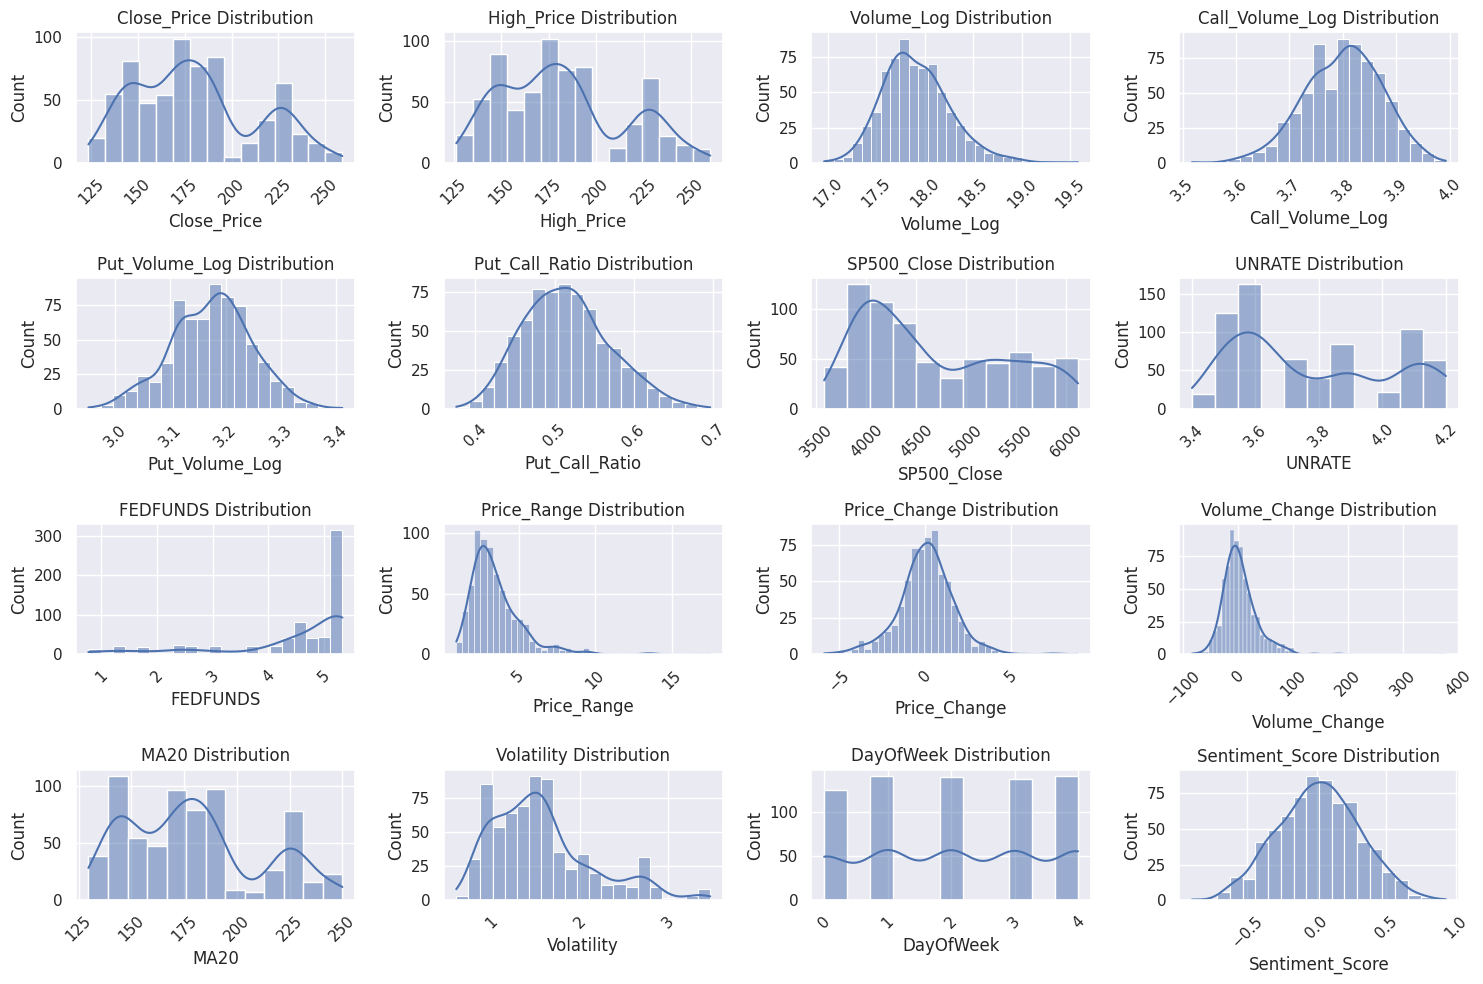

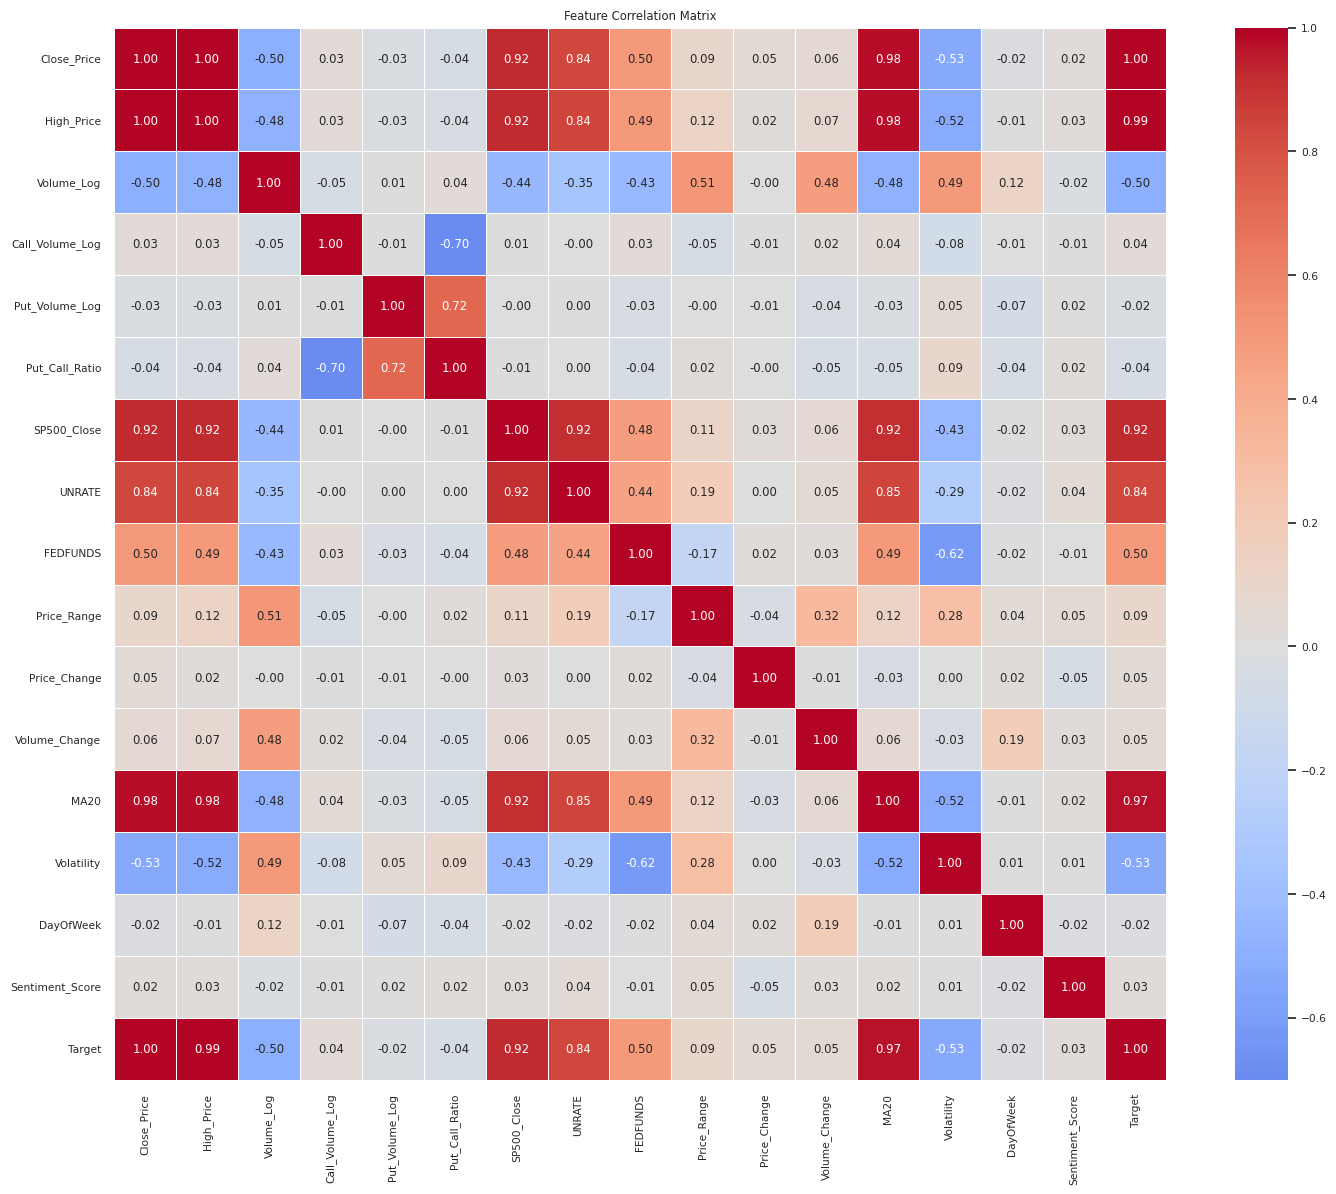

Data shapes:
Training set: (375, 60, 19)
Validation set: (125, 60, 19)
Test set: (125, 60, 19)


In [119]:
if __name__ == "__main__":
    file_path = "comprehensive_stock_data.xlsx"
    data_dict = prepare_data_for_training(file_path)

    # Plot distributions and correlations with improved plotting functions
    plot_data_distribution(data_dict['original_df'], data_dict['feature_columns'])
    plot_correlation_matrix(data_dict['original_df'], data_dict['feature_columns'])

    print("Data shapes:")
    print(f"Training set: {data_dict['X_train'].shape}")
    print(f"Validation set: {data_dict['X_valid'].shape}")
    print(f"Test set: {data_dict['X_test'].shape}")

# New Section

In [128]:
# Common Evaluation Functions
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return mse, rmse, mae, r2

In [129]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'{model_name} - Actual vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [130]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [131]:
# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(80, return_sequences=True, input_shape=input_shape),
        Dropout(0.4),
        LSTM(20, return_sequences=False),
        Dropout(0.4),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [132]:
# GRU Model
def create_gru_model(input_shape):
    model = Sequential([
        GRU(80, return_sequences=True, input_shape=input_shape),
        Dropout(0.4),
        GRU(20, return_sequences=False),
        Dropout(0.4),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [133]:
# CNN_LSTM Model
def create_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=45, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(filters=20, kernel_size=3, activation='relu'),
        BatchNormalization(),
        LSTM(80, return_sequences=True),
        Dropout(0.4),
        LSTM(20, return_sequences=False),
        Dropout(0.4),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [134]:
#Transformer Model
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Multi-Head Attention Layer
    attention = MultiHeadAttention(num_heads=4, key_dim=input_shape[-1])(inputs, inputs)
    x = BatchNormalization()(attention)
    x = Flatten()(x)

    # Dense layers
    x = Dense(80, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


In [135]:
#MLP Model
def create_mlp_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(140, activation='relu'),
        Dropout(0.4),
        Dense(60, activation='relu'),
        Dropout(0.4),
        Dense(20, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [136]:
# Neuro-Fuzzy Model (Adaptive Neuro-Fuzzy Inference System - ANFIS)
def create_neurofuzzy_model(input_shape):
    """
    Create a Neuro-Fuzzy model using Keras
    """
    # Neuro-Fuzzy model implementation
    inputs = Input(shape=input_shape)

    # Flatten the input sequence
    x = Lambda(lambda t: tf.reshape(t, [-1, np.prod(input_shape)]))(inputs)

    # Fuzzy layer (membership functions)
    x = Dense(input_shape[1] * 3, activation='sigmoid')(x)  # 3 membership functions per feature

    # Rule layer (fuzzy rules)
    x = Dense(30, activation='relu')(x)

    # Defuzzification layer
    x = Dense(15, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(10, activation='relu')(x)

    # Output layer
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')

    return model

In [137]:
# Training function for deep learning models
def train_model(model, model_name, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=100):
    print(f"\nTraining {model_name}...")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )

    # Make predictions
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)

    # Plot training history
    plot_training_history(history, model_name)

    # Evaluate on all sets
    print("\nTraining Set Metrics:")
    train_metrics = evaluate_model(y_train, train_pred, f"{model_name} (Training)")
    plot_predictions(y_train, train_pred, f"{model_name} (Training)")

    print("\nValidation Set Metrics:")
    valid_metrics = evaluate_model(y_valid, valid_pred, f"{model_name} (Validation)")
    plot_predictions(y_valid, valid_pred, f"{model_name} (Validation)")

    print("\nTest Set Metrics:")
    test_metrics = evaluate_model(y_test, test_pred, f"{model_name} (Test)")
    plot_predictions(y_test, test_pred, f"{model_name} (Test)")

    return {
        'model': model,
        'history': history,
        'predictions': {
            'train': train_pred,
            'valid': valid_pred,
            'test': test_pred
        },
        'metrics': {
            'train': train_metrics,
            'valid': valid_metrics,
            'test': test_metrics
        }
    }

In [138]:
# Train all models
def train_all_models(X_train, y_train, X_valid, y_valid, X_test, y_test):
    input_shape = (X_train.shape[1], X_train.shape[2])
    results = {}

    # Train LSTM
    lstm_model = create_lstm_model(input_shape)
    results['LSTM'] = train_model(lstm_model, "LSTM", X_train, y_train, X_valid, y_valid, X_test, y_test)

    # Train GRU
    gru_model = create_gru_model(input_shape)
    results['GRU'] = train_model(gru_model, "GRU", X_train, y_train, X_valid, y_valid, X_test, y_test)

    # Train CNN-LSTM
    cnn_lstm_model = create_cnn_lstm_model(input_shape)
    results['CNN-LSTM'] = train_model(cnn_lstm_model, "CNN-LSTM", X_train, y_train, X_valid, y_valid, X_test, y_test)

    # Train Transformer
    transformer_model = create_transformer_model(input_shape)
    results['Transformer'] = train_model(transformer_model, "Transformer", X_train, y_train, X_valid, y_valid, X_test, y_test)

    # Train MLP
    mlp_model = create_mlp_model(input_shape)
    results['MLP'] = train_model(mlp_model, "MLP", X_train, y_train, X_valid, y_valid, X_test, y_test)

    # Train Neuro-Fuzzy Model
    neurofuzzy_model = create_neurofuzzy_model(input_shape)
    results['Neuro-Fuzzy'] = train_model(neurofuzzy_model, "Neuro-Fuzzy", X_train, y_train, X_valid, y_valid, X_test, y_test)


    return results

# Compare all models
def compare_models(results):
    models = list(results.keys())
    metrics = ['MSE', 'RMSE', 'MAE', 'R2']

    comparison_data = {
        'Model': [],
        'Metric': [],
        'Train': [],
        'Validation': [],
        'Test': []
    }

    for model_name in models:
        for i, metric in enumerate(metrics):
            comparison_data['Model'].append(model_name)
            comparison_data['Metric'].append(metric)
            comparison_data['Train'].append(results[model_name]['metrics']['train'][i])
            comparison_data['Validation'].append(results[model_name]['metrics']['valid'][i])
            comparison_data['Test'].append(results[model_name]['metrics']['test'][i])

    comparison_df = pd.DataFrame(comparison_data)

    # Plot comparison
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        metric_data = comparison_df[comparison_df['Metric'] == metric]

        x = np.arange(len(models))
        width = 0.25

        plt.bar(x - width, metric_data['Train'], width, label='Train')
        plt.bar(x, metric_data['Validation'], width, label='Validation')
        plt.bar(x + width, metric_data['Test'], width, label='Test')

        plt.title(f'{metric} Comparison')
        plt.xticks(x, models, rotation=45)
        plt.legend()

    plt.tight_layout()
    plt.show()

    return comparison_df



Training LSTM...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0511 - val_loss: 0.0173
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0109 - val_loss: 0.0202
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0091 - val_loss: 0.0173
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0072 - val_loss: 0.0130
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0078 - val_loss: 0.0135
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0066 - val_loss: 0.0139
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0055 - val_loss: 0.0140
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0048 - val_loss: 0.0160
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0056 - val_loss: 0.0127
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0045 - val_loss: 0.0125
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 

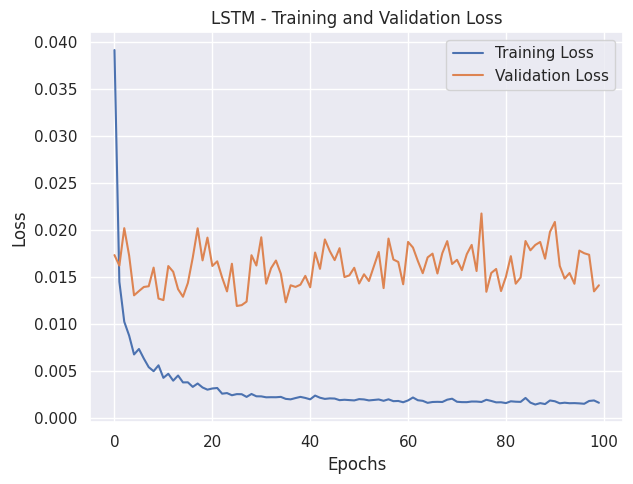


Training Set Metrics:

LSTM (Training) Performance Metrics:
MSE: 0.0013
RMSE: 0.0361
MAE: 0.0285
R2 Score: 0.9359


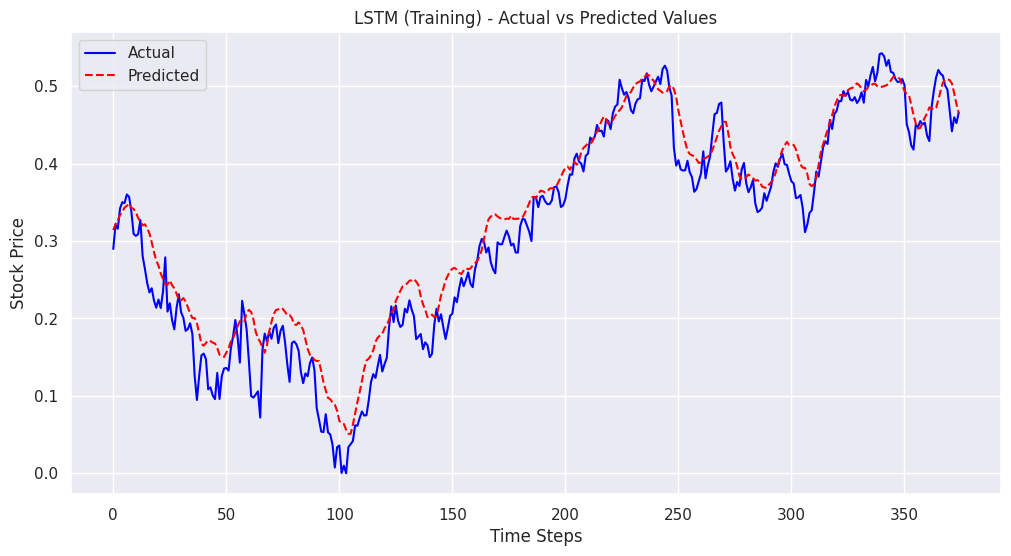


Validation Set Metrics:

LSTM (Validation) Performance Metrics:
MSE: 0.0141
RMSE: 0.1188
MAE: 0.0886
R2 Score: 0.3862


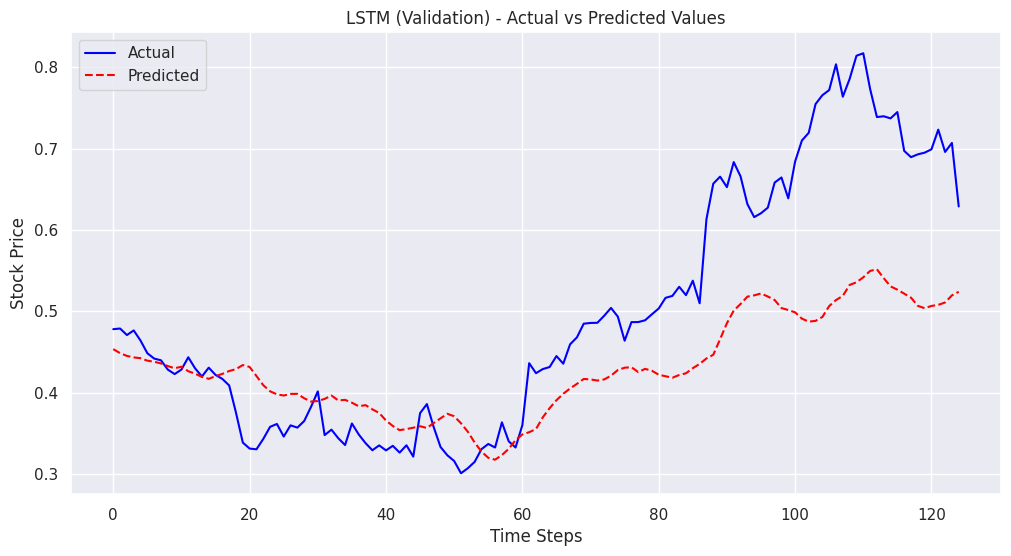


Test Set Metrics:

LSTM (Test) Performance Metrics:
MSE: 0.0589
RMSE: 0.2427
MAE: 0.2369
R2 Score: -8.8938


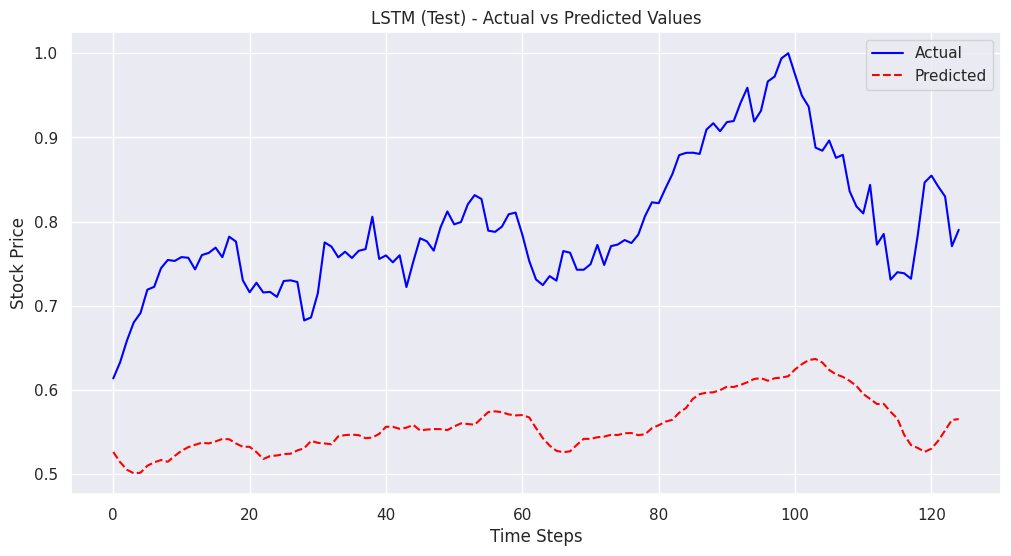


Training GRU...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.0494 - val_loss: 0.0477
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0109 - val_loss: 0.0219
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0099 - val_loss: 0.0156
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0095 - val_loss: 0.0165
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0074 - val_loss: 0.0192
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0060 - val_loss: 0.0164
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0047 - val_loss: 0.0135
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0038 - val_loss: 0.0103
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0041 - val_loss: 0.0151
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0048 - val_loss: 0.0144
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss

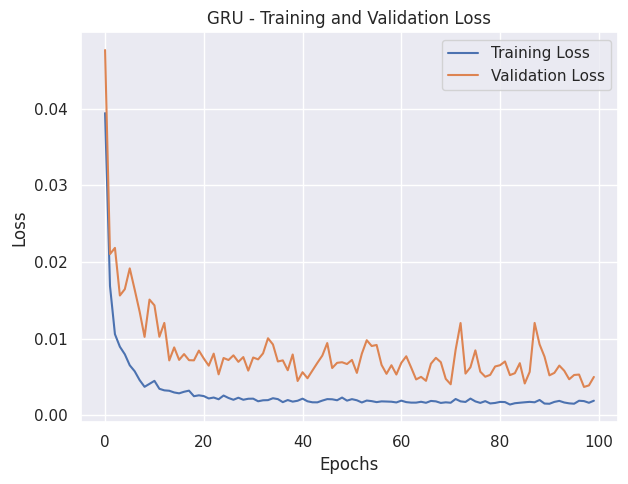


Training Set Metrics:

GRU (Training) Performance Metrics:
MSE: 0.0009
RMSE: 0.0302
MAE: 0.0236
R2 Score: 0.9553


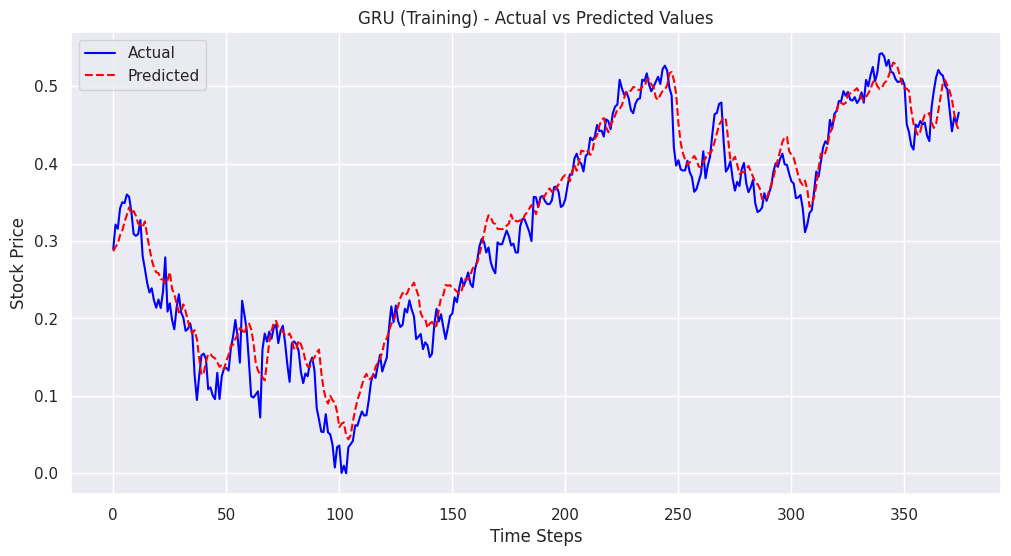


Validation Set Metrics:

GRU (Validation) Performance Metrics:
MSE: 0.0050
RMSE: 0.0709
MAE: 0.0538
R2 Score: 0.7812


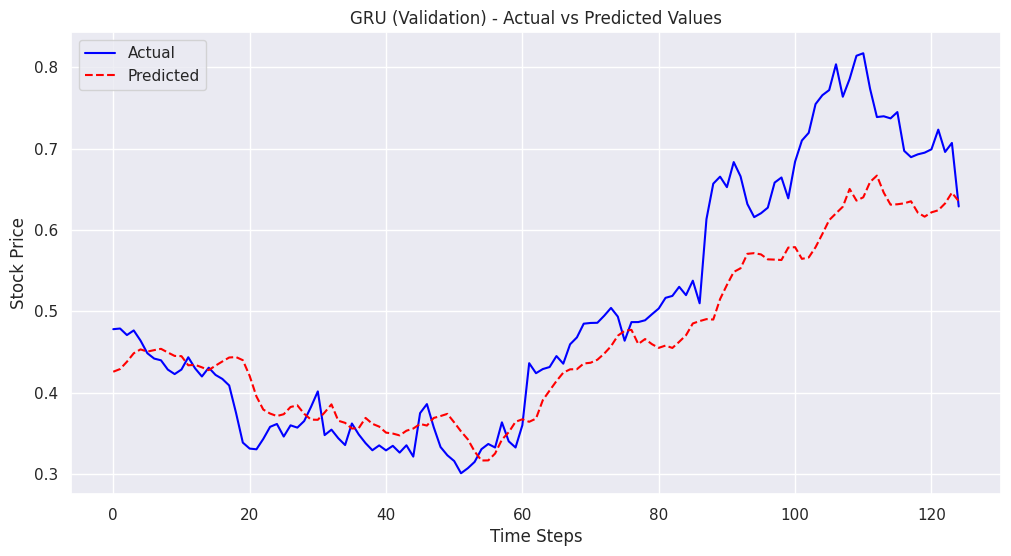


Test Set Metrics:

GRU (Test) Performance Metrics:
MSE: 0.0175
RMSE: 0.1323
MAE: 0.1248
R2 Score: -1.9391


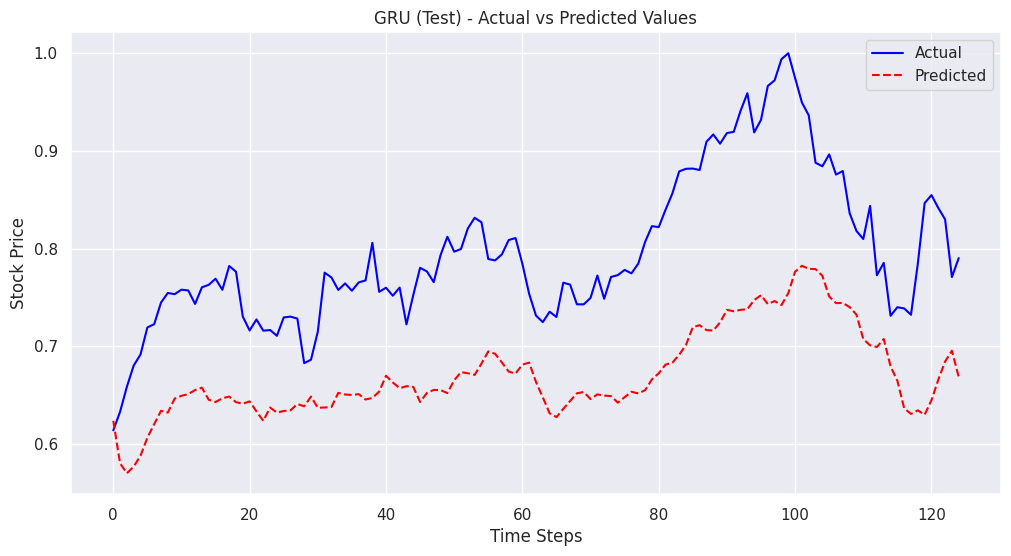

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN-LSTM...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 0.0725 - val_loss: 0.1567
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0153 - val_loss: 0.1201
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0120 - val_loss: 0.0945
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0071 - val_loss: 0.0812
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0059 - val_loss: 0.0698
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0058 - val_loss: 0.0667
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0051 - val_loss: 0.0630
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0047 - val_loss: 0.0661
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0048 - val_loss: 0.0563
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0035 - val_loss: 0.0539
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0046 - val_loss: 0.0593
Epoch 12/100
12/12 ━━━━━━━━

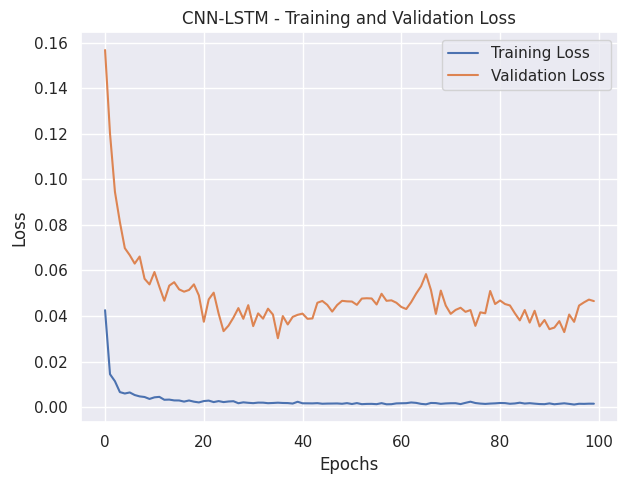


Training Set Metrics:

CNN-LSTM (Training) Performance Metrics:
MSE: 0.0005
RMSE: 0.0225
MAE: 0.0185
R2 Score: 0.9750


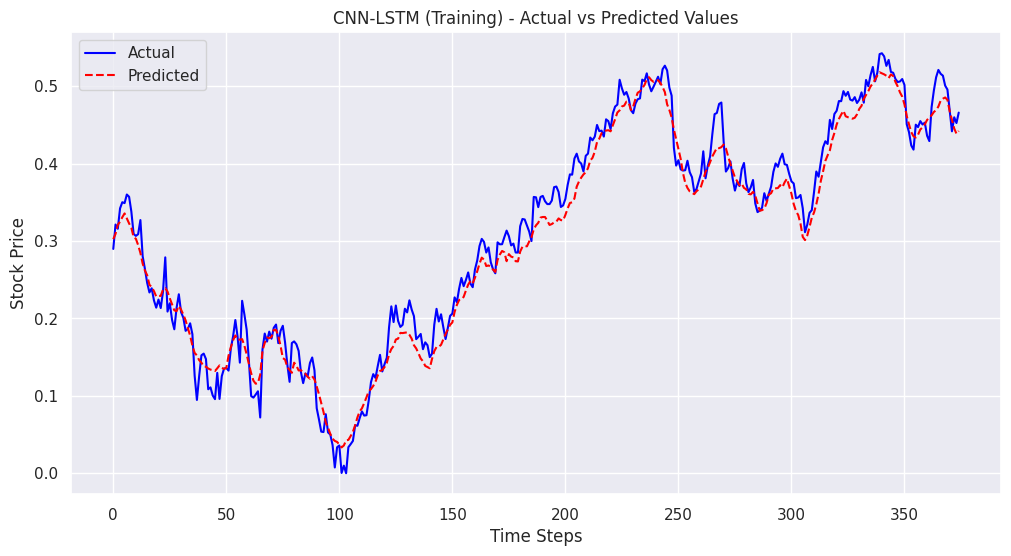


Validation Set Metrics:

CNN-LSTM (Validation) Performance Metrics:
MSE: 0.0465
RMSE: 0.2157
MAE: 0.1629
R2 Score: -1.0254


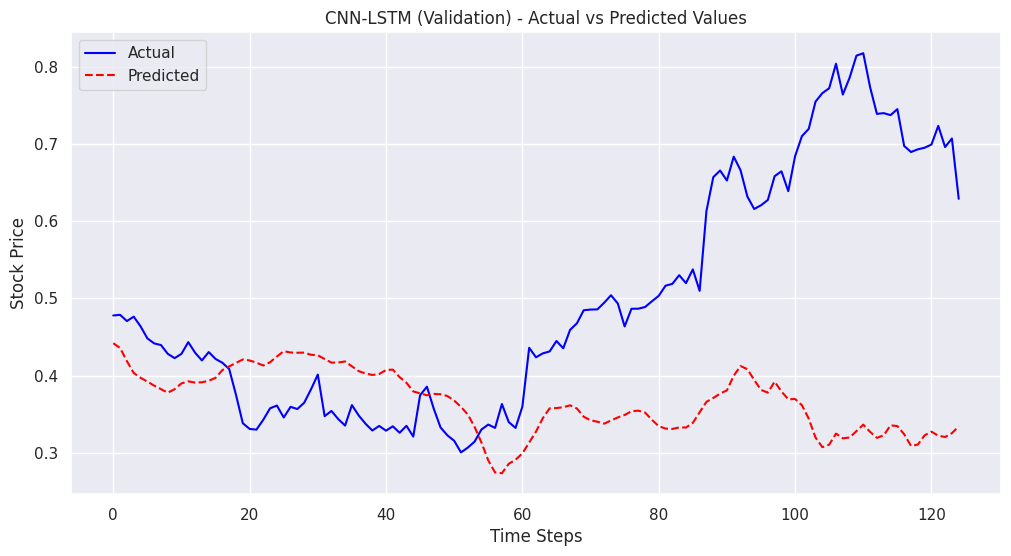


Test Set Metrics:

CNN-LSTM (Test) Performance Metrics:
MSE: 0.1847
RMSE: 0.4297
MAE: 0.4249
R2 Score: -30.0219


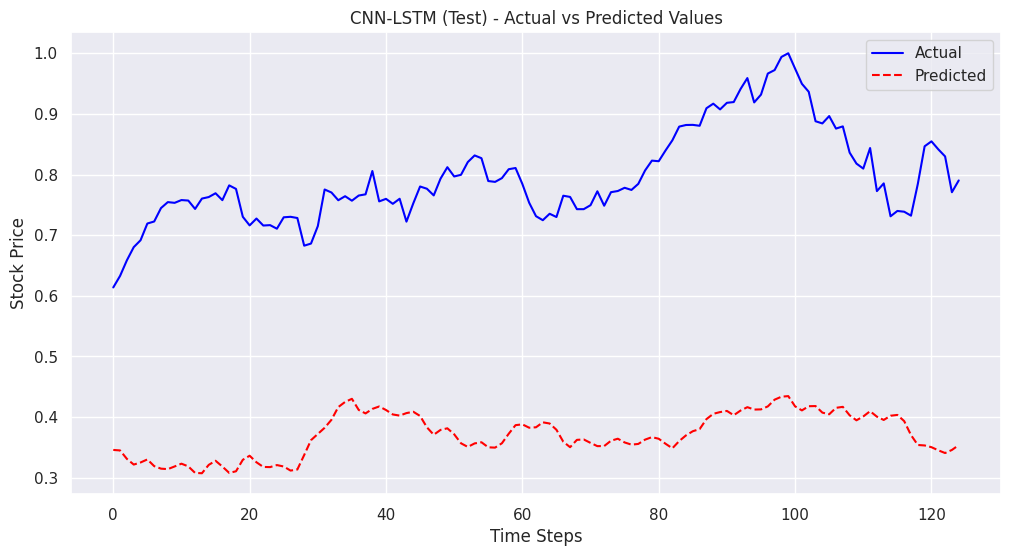


Training Transformer...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 1.2861 - val_loss: 0.2380
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2531 - val_loss: 0.2018
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1212 - val_loss: 0.2154
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0726 - val_loss: 0.1982
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0459 - val_loss: 0.2057
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0431 - val_loss: 0.2010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0433 - val_loss: 0.2060
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0375 - val_loss: 0.1912
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0315 - val_loss: 0.1849
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0327 - val_loss: 0.1744
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0274 - val_loss: 0.1694
Epoch 12/100
12/12 ━━━━━━━━

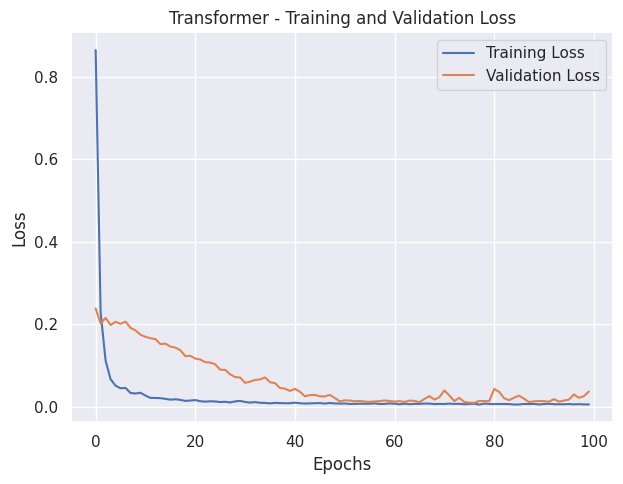


Training Set Metrics:

Transformer (Training) Performance Metrics:
MSE: 0.0171
RMSE: 0.1307
MAE: 0.1142
R2 Score: 0.1610


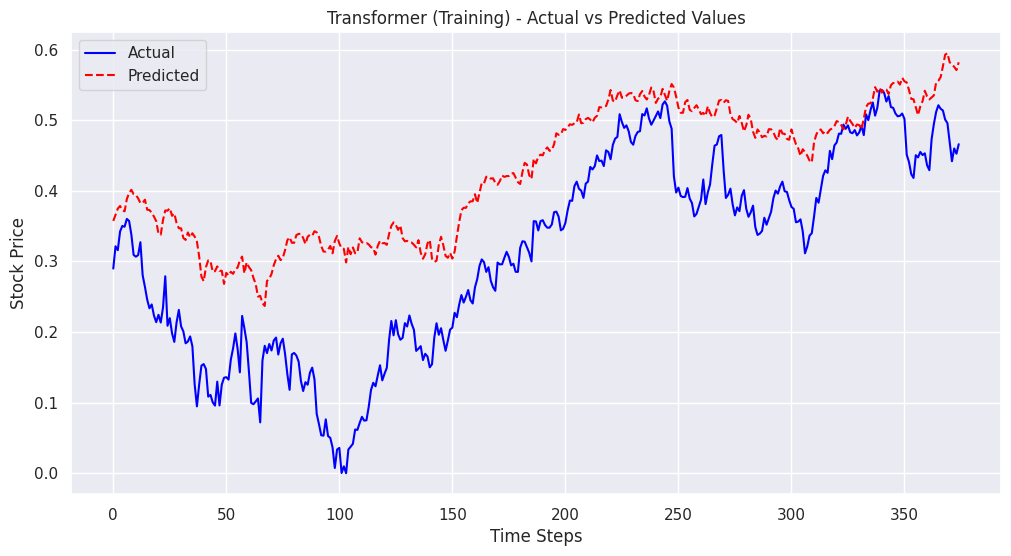


Validation Set Metrics:

Transformer (Validation) Performance Metrics:
MSE: 0.0364
RMSE: 0.1909
MAE: 0.1687
R2 Score: -0.5861


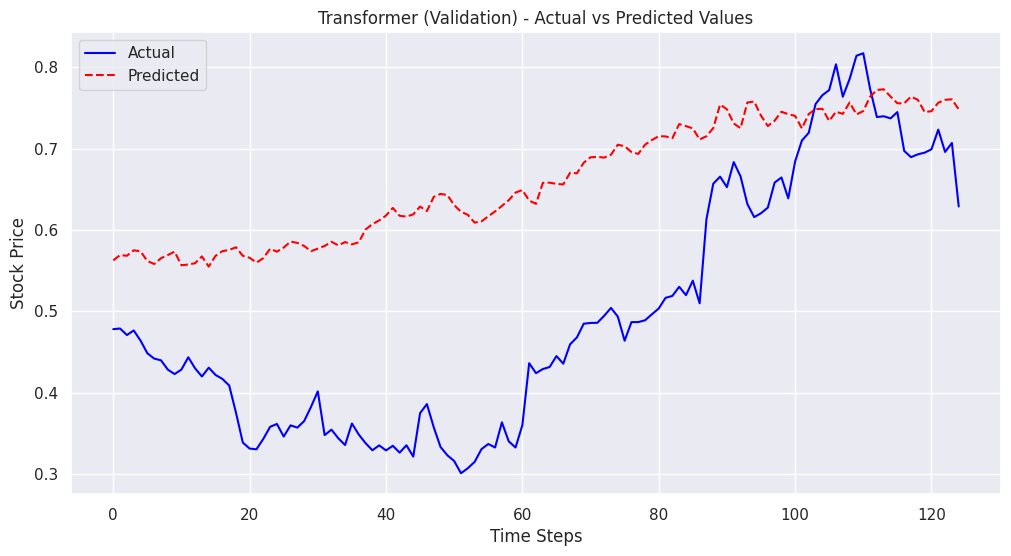


Test Set Metrics:

Transformer (Test) Performance Metrics:
MSE: 0.0032
RMSE: 0.0566
MAE: 0.0433
R2 Score: 0.4609


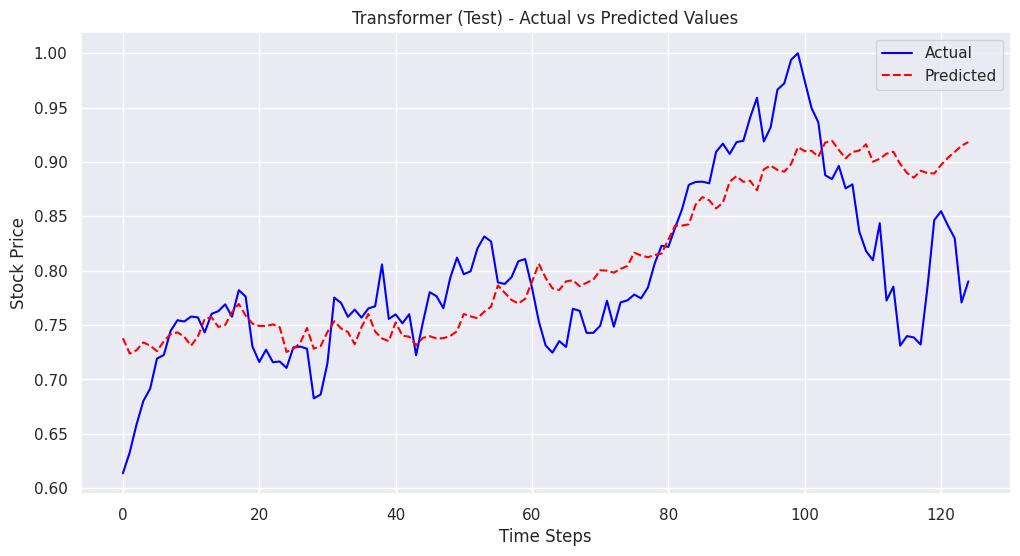


Training MLP...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2262 - val_loss: 0.0799
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0632 - val_loss: 0.1089
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0520 - val_loss: 0.0870
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0336 - val_loss: 0.0597
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0270 - val_loss: 0.0491
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0215 - val_loss: 0.0414
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0169 - val_loss: 0.0606
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0170 - val_loss: 0.0461
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0172 - val_loss: 0.0410
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0150 - val_loss: 0.0418
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0143 - val_loss: 0.0506
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

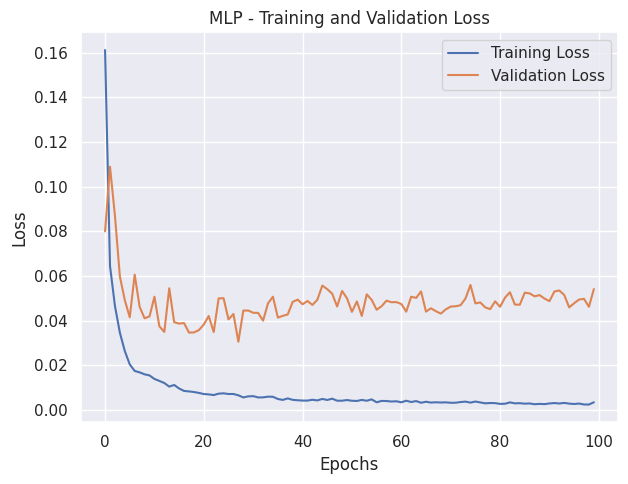


Training Set Metrics:

MLP (Training) Performance Metrics:
MSE: 0.0101
RMSE: 0.1004
MAE: 0.0799
R2 Score: 0.5048


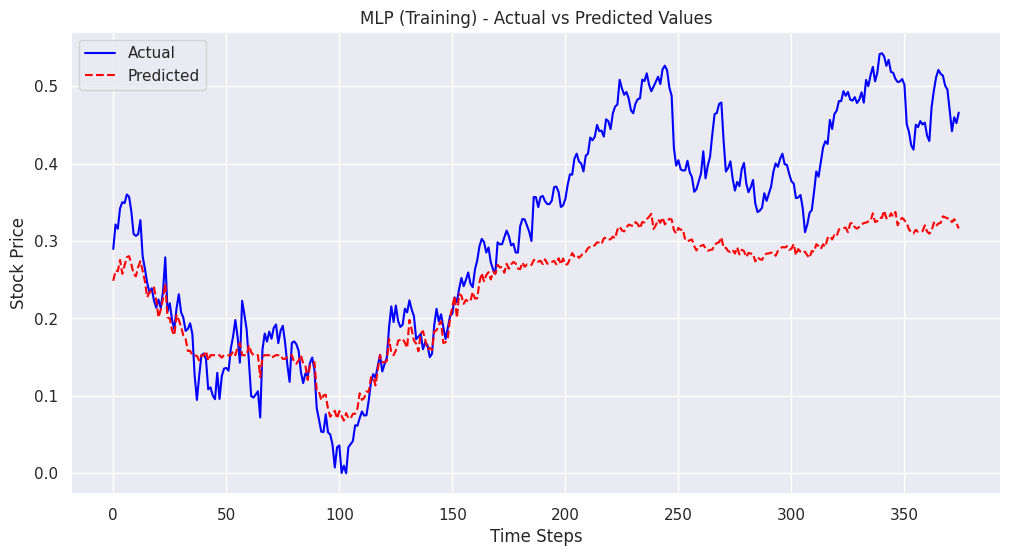


Validation Set Metrics:

MLP (Validation) Performance Metrics:
MSE: 0.0541
RMSE: 0.2325
MAE: 0.1889
R2 Score: -1.3535


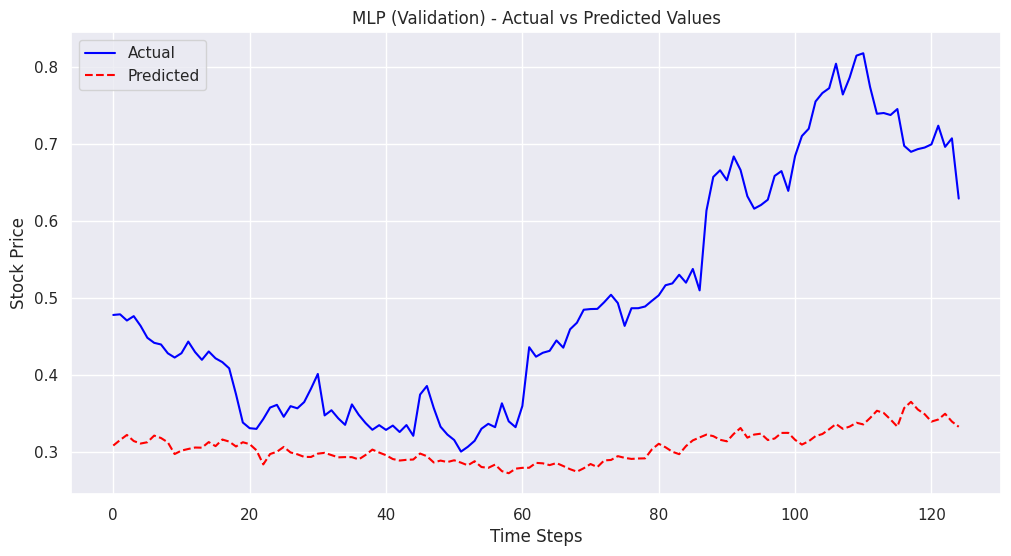


Test Set Metrics:

MLP (Test) Performance Metrics:
MSE: 0.1774
RMSE: 0.4212
MAE: 0.4169
R2 Score: -28.8074


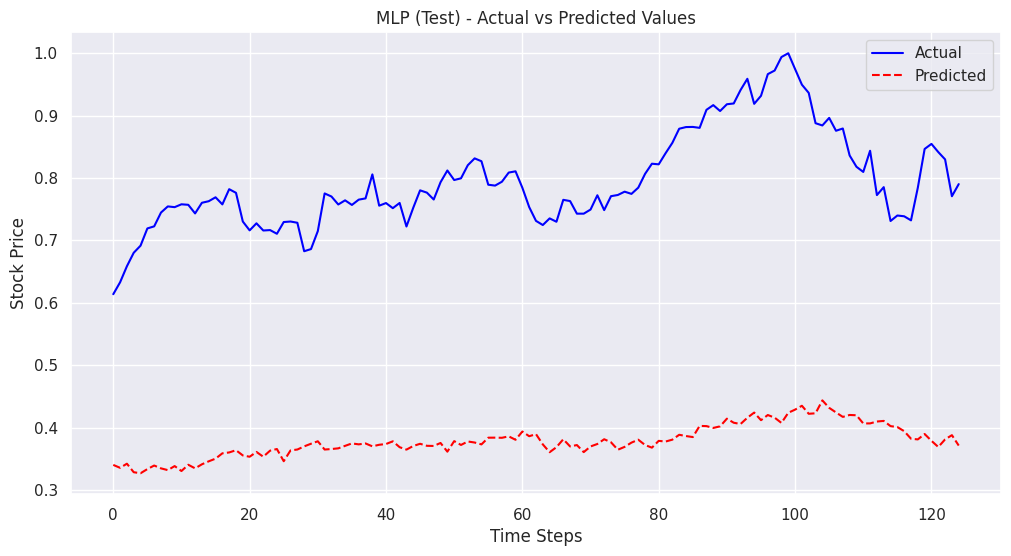


Training Neuro-Fuzzy...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0847 - val_loss: 0.0861
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0218 - val_loss: 0.0748
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0133 - val_loss: 0.0503
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0109 - val_loss: 0.0420
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087 - val_loss: 0.0422
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065 - val_loss: 0.0457
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0089 - val_loss: 0.0380
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084 - val_loss: 0.0454
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080 - val_loss: 0.0466
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0064 - val_loss: 0.0516
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 - val_loss: 0.0410
Epoch 12/100
12/12 ━━━━━━━━

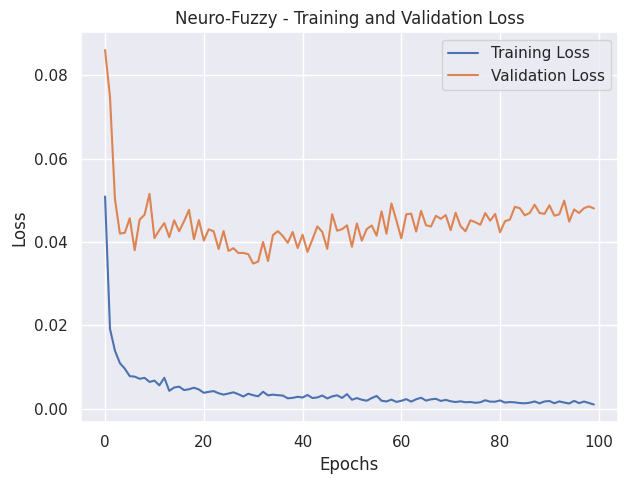


Training Set Metrics:

Neuro-Fuzzy (Training) Performance Metrics:
MSE: 0.0057
RMSE: 0.0757
MAE: 0.0613
R2 Score: 0.7184


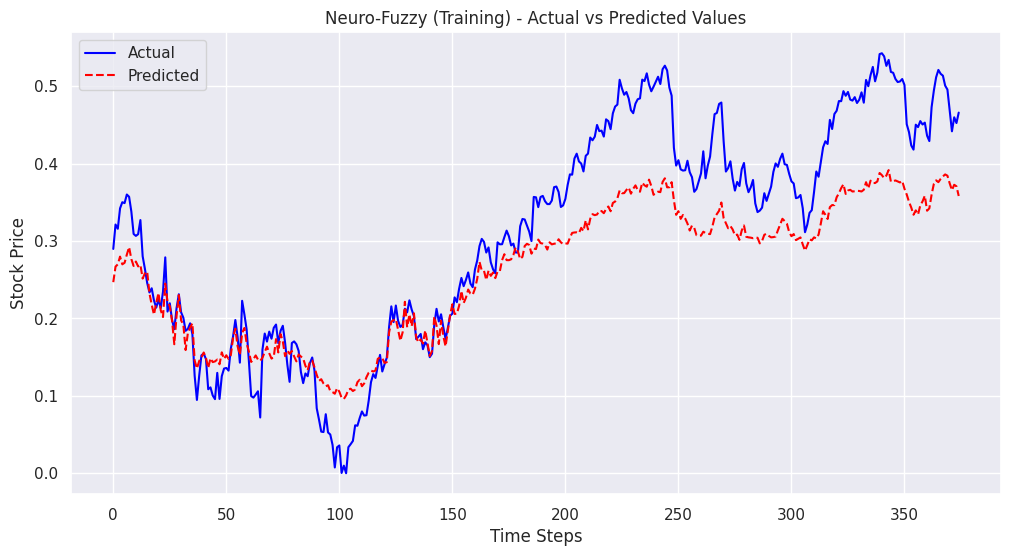


Validation Set Metrics:

Neuro-Fuzzy (Validation) Performance Metrics:
MSE: 0.0481
RMSE: 0.2193
MAE: 0.1717
R2 Score: -1.0920


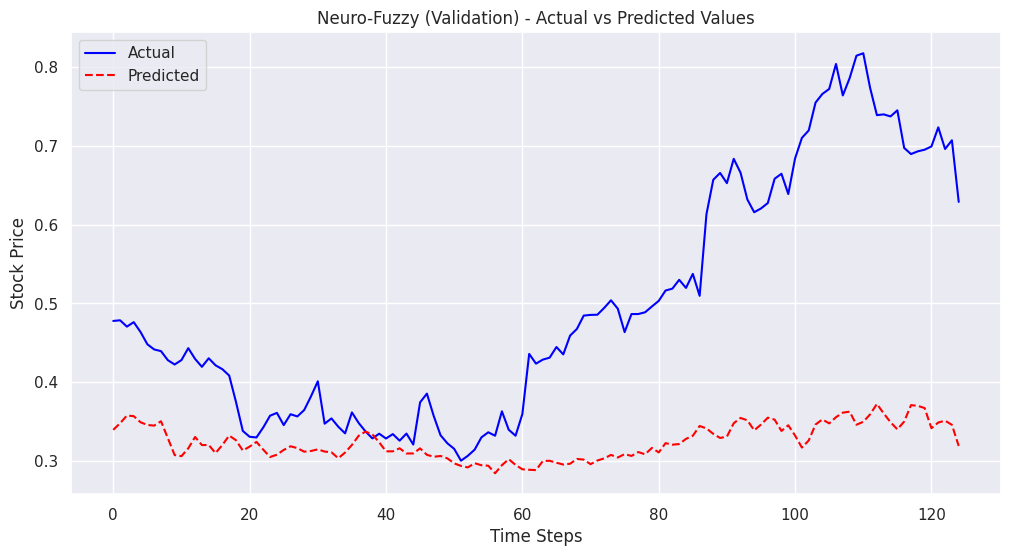


Test Set Metrics:

Neuro-Fuzzy (Test) Performance Metrics:
MSE: 0.1568
RMSE: 0.3960
MAE: 0.3925
R2 Score: -25.3440


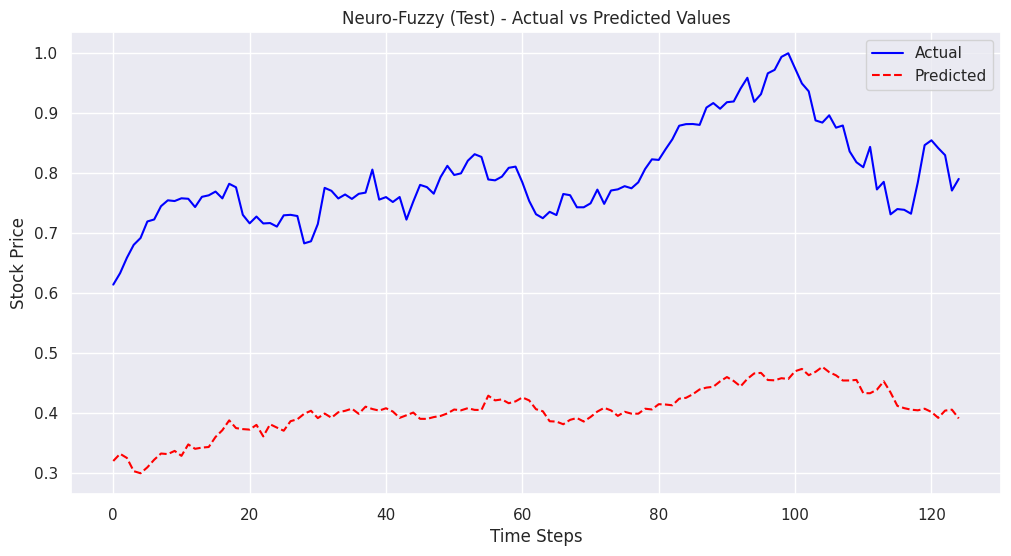

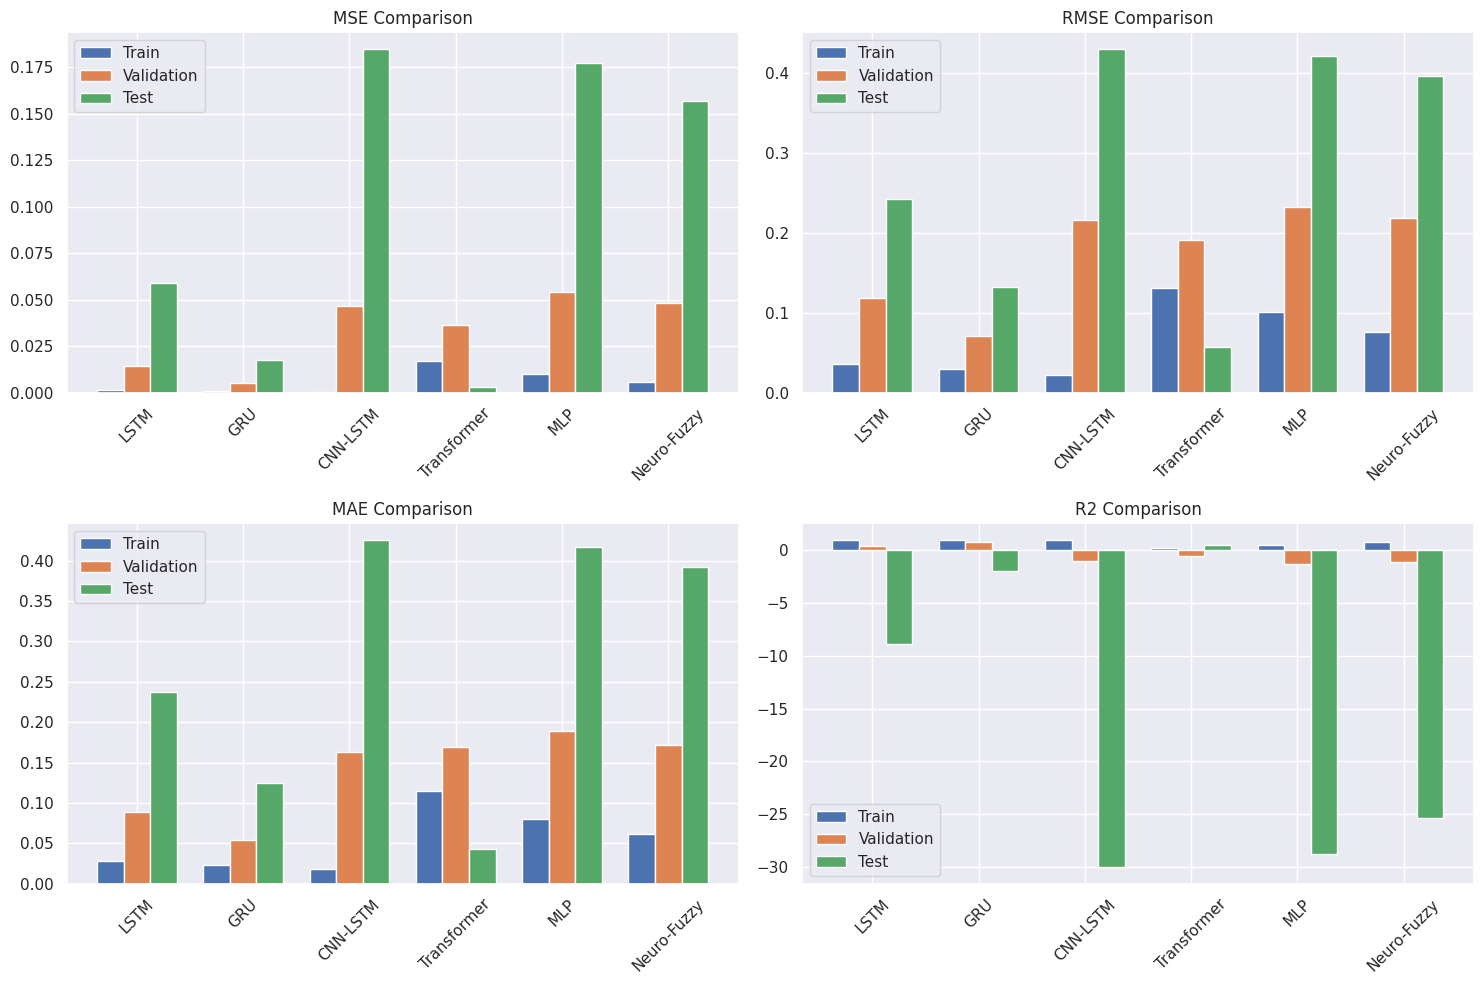


Model Comparison:
          Model Metric     Train  Validation       Test
0          LSTM    MSE  0.001305    0.014103   0.058893
1          LSTM   RMSE  0.036127    0.118758   0.242678
2          LSTM    MAE  0.028497    0.088613   0.236927
3          LSTM     R2  0.935922    0.386224  -8.893822
4           GRU    MSE  0.000911    0.005029   0.017495
5           GRU   RMSE  0.030175    0.070913   0.132268
6           GRU    MAE  0.023600    0.053753   0.124803
7           GRU     R2  0.955296    0.781153  -1.939086
8      CNN-LSTM    MSE  0.000508    0.046540   0.184657
9      CNN-LSTM   RMSE  0.022549    0.215731   0.429717
10     CNN-LSTM    MAE  0.018510    0.162939   0.424895
11     CNN-LSTM     R2  0.975036   -1.025414 -30.021886
12  Transformer    MSE  0.017088    0.036445   0.003209
13  Transformer   RMSE  0.130722    0.190905   0.056648
14  Transformer    MAE  0.114170    0.168741   0.043325
15  Transformer     R2  0.161035   -0.586074   0.460902
16          MLP    MSE  0.010

In [139]:
# Main execution
def main():
    # File path for your data
    file_path = "comprehensive_stock_data.xlsx"

    # Prepare data
    data_dict = prepare_data_for_training(file_path)

    # Train all models
    results = train_all_models(
        data_dict['X_train'],
        data_dict['y_train'],
        data_dict['X_valid'],
        data_dict['y_valid'],
        data_dict['X_test'],
        data_dict['y_test']
    )

    # Compare models
    comparison_df = compare_models(results)

    # Print comparison results
    print("\nModel Comparison:")
    print(comparison_df)

# Run the main function
if __name__ == "__main__":
    main()